In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import os

# Shutil is a recursive tool to delete file paths
# Note: Only needed if you plan to overwrite existing filepaths
import shutil

# Function: generateData
### Performs OLS on every edge and saves a, b into csv and json files 

> (bool) freight : Freight mode calculation on or off
(str) dataSourcePath : Source data file path (.xlsx)
(str) saveFolderName : Name of the folder to save the data (non-existing)

#### Note:  -1 is a placeholder for N/A values (self loops)

In [19]:
# This function will store the sampled data into multiple csv files.
def generateData (freight = True, dataSourcePath = 'Batch_Div27_Class8_bev_1_Results_metrics.xlsx', saveFolderName = "OLS_Data"):
    parent_dir = os.getcwd()
    savePath = os.path.join(parent_dir, saveFolderName)
    
    # If the folder already exists, remove the folder
    if os.path.exists(savePath):
        shutil.rmtree(savePath)
    os.makedirs(savePath)
    
    # Load and trim Data
    data = pd.read_excel(dataSourcePath, index_col=None)
    df = data.loc[:, ['Vehicle Model-none',\
                      'Battery Energy Consumption per Mile-kWh/mi',\
                      'Vehicle Static Mass-lbm',\
                      'Cargo Mass-lbm']]
    
    # Getting information from the table
    vehicleTypes = pd.Series(data['Vehicle Model-none'].values).unique()
    
    # Function to look for the number of nodes from a list of strings in the source file
    def findNumNodes(sentence_arr):
        running_max = 1
        length = len(sentence_arr)
        i_val = np.full(length, 0)
        j_val = np.full(length, 0)
        for index, sentence in enumerate(sentence_arr):

            # Split the string, and get the corresponding node values
            temp = sentence.lower().split('div')[1].split('_raw')[0].split('_')
            j = temp[-1]
            i = temp[-2]
            j = int(''.join([x for x in j if x.isdigit()]))
            i = int(''.join([x for x in i if x.isdigit()]))
            running_max = max(i, j, running_max)
            i_val[index], j_val[index] = i, j
        return running_max, i_val, j_val
    
    # Adding "i" and "j" columns for lookup convenience later in code
    numNodes, i_val, j_val = findNumNodes(data["Cycle Source-none"].values)
    print("Number Of Nodes: ", numNodes)
    data = 0 # Release Memory
    df['i'], df['j'] = i_val, j_val
    
    # Setup for csv files index and column labels
    cols = ["i_" + str(i) for i in range(1, numNodes+1)]
    rows = ["j_" + str(i) for i in range(1, numNodes+1)]
                   
    # Loop for Vehicle Types (k)
    for v in vehicleTypes:
        workFrame = df[df["Vehicle Model-none"] == v]
        newFrame = pd.DataFrame(columns = cols, index = rows)
        
        # Iterate over node values i, j, and assign constants a, b, into "newFrame"
        for i in range(1, numNodes + 1):
            for j in range(1, numNodes + 1):
                
                # This line below gives a frame of the cost of an edge
                data = workFrame.loc[((workFrame['i'] == i) & (workFrame['j'] == j))]

                # edge case if i = j or data Doesn't exist
                if i == j :
                    newFrame.iat[i-1, j-1] = -1
                    continue
                if data.size == 0:
                    newFrame.iat[i-1, j-1] = 0
                    continue
                
                # Doing linear regression here
                if freight:
                    # Set training data to be Cargo data
                    X = (data.loc[:, ['Cargo Mass-lbm']]*0.453592).values.reshape(-1, 1)
                    
                else:
                    X = (data.loc[:, ['Vehicle Static Mass-lbm']]*0.453592).values.reshape(-1, 1)

                Y = (data.loc[:, ['Battery Energy Consumption per Mile-kWh/mi']]/1.60934).values.reshape(-1, 1)
                LR = LinearRegression()  # create object for the class
                LR.fit(X, Y)  # perform linear regression
                
                # Assigning the calculated a, b params
                newFrame.iat[i - 1, j - 1] = (LR.coef_.item(0), LR.intercept_.item(0))

        # Create the filePath
        tempPath2 = os.path.join(savePath, v + ".csv")
        tempPath3 = os.path.join(savePath, v + ".json")
        newFrame.to_csv(tempPath2)
        newFrame.to_json(tempPath3)

In [66]:
# Testing generation using scikit-learn

dataSourcePath = 'Batch_Div27_Class8_2_Results_metrics_BEV.xlsx'

# Testing generation using scikit-learn
data = pd.read_excel(dataSourcePath, index_col=None)
df = data.loc[:, ['Vehicle Model-none',\
        'Battery Energy Consumption per Mile-kWh/mi',\
        'Vehicle Static Mass-lbm',\
        'Cargo Mass-lbm']]

# Function to look for the number of nodes from a list of strings in the source file
def findInt(sentence_arr):
    running_max = 1
    length = len(sentence_arr)
    i_val = np.full(length, 0)
    j_val = np.full(length, 0)
    for index, sentence in enumerate(sentence_arr):
        digits = [int(i) for i in sentence if i.isdigit()] 
        running_max = max(digits[-1], digits[-2], running_max)
        i_val[index], j_val[index] = digits[-2], digits[-1]
    return running_max, i_val, j_val

# Adding "i" and "j" columns for lookup convenience later in code
numNodes, i_val, j_val = findInt(data["Cycle Source-none"].values)
df['i'], df['j'] = i_val, j_val

In [17]:
workFrame = df[df["Vehicle Model-none"] == 'class8_bev_2021_low_sleeper_longhaul_FU19']

data = workFrame.loc[((workFrame['i'] == 1) & (workFrame['j'] == 2))]

train_data = data.loc[:, ['Cargo Mass-lbm']]*0.453592
train_data.columns = ['CargoMass_kg']
train_data['Energy_kwh_km'] = data.loc[:, ['Battery Energy Consumption per Mile-kWh/mi']]/1.60934

X = train_data.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = train_data.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

In [27]:
train_data.iloc[:, 0]
linear_regressor.coef_, linear_regressor.intercept_

(array([[2.74025726e-05]]), array([1.11094288]))

In [20]:
generateData(freight = True, dataSourcePath = 'Batch_Div27_Class8_bev_1_Results_metrics.xlsx', saveFolderName = "OLS_Data")

Number Of Nodes:  18
[[    0.      ]
 [    0.      ]
 [ 3521.234696]
 [ 7042.469392]
 [10563.704088]
 [14084.938784]]
[[    0.      ]
 [    0.      ]
 [ 3521.234696]
 [ 7042.469392]
 [10563.704088]
 [14084.938784]]
Repetition Error


In [77]:
dataSourcePath = 'Batch_Div27_Class8_bev_1_Results_metrics.xlsx'
data = pd.read_excel(dataSourcePath, index_col=None)

In [78]:
data["Cycle Source-none"].values

array(['Div27_N1_N2_Raw_Class_8', 'Div27_N1_N2_Raw_Class_8',
       'Div27_N1_N2_Raw_Class_8', ..., 'Div27_N18_N17_Raw_Class_8',
       'Div27_N18_N17_Raw_Class_8', 'Div27_N18_N17_Raw_Class_8'],
      dtype=object)

In [82]:
sentence = "Div27_N1_N18_Raw_Class_8"
temp = sentence.lower().split('div')[1].split('_raw')[0].split('_')
j = temp[-1]
i = temp[-2]
j = int(''.join([x for x in j if x.isdigit()]))
i = int(''.join([x for x in i if x.isdigit()]))
i, j

(1, 18)

In [ ]:
plt.plot(X, Y_pred, color='red')

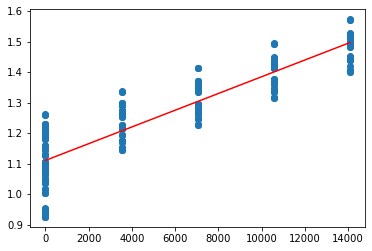

In [31]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# Function: readData
 ### Reads the source folder generated by the  "generateData" function returns a, b, as dictionaries.
> Input:  
(str) saveFolderName: Folder Name of the folder created by generateData
  
Output: 
>a [ k ][ i ][ j ]  
b [ k ][ i ][ j ] 


>k : Vehiecle Type (string)    
i : Node  (int), index starts from 1  
j : Node  (int), index starts from 1  

#### Note:  -1 is a placeholder for N/A values (self loops) and -2 is used as padding (for lookup convenience) 

In [195]:
# Reads out the data and collects them into a dictionary.
def readDataCSV (saveFolderName = "OLS_Data"):
    
    # Initialize some folderpath
    path = os.path.join(os.getcwd(), saveFolderName)
    
    # If the folder doesn't exist, print error and return
    if not os.path.exists(path):
        print("Error, Source Folder Doesn't exist")
        return 
    VehiecleTypesPath = [ fi for fi in os.listdir(path) if fi.endswith(".json") ]
    VehiecleTypes = [i[:len(i) - 5] for i in VehiecleTypesPath]
    
    # Get the number of nodes brute forcedly
    filePath = os.path.join(path, VehiecleTypesPath[0])
    df = pd.read_json(filePath)
    numNodes = np.shape(df.iloc[:, 0].values)[0]
    
    # Initializing return dictionary
    a = {}
    b = {}

    for ind, v in enumerate(VehiecleTypes):
        # initialize an empty array to store the days
        a[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = np.float64)
        b[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = np.float64)
        
        results = df.to_numpy().transpose()
        for i, temp in enumerate(results, 1):
            for j, ab in enumerate(temp, 1):
                if type(ab) == list:
                    a[v][i][j], b[v][i][j] = ab[0], ab[1] 
                else:
                    a[v][i][j], b[v][i][j] = ab, ab
                    
    return a, b

In [196]:
a, b = readDataCSV()

In [197]:
a

{'class8_bev_2021_daycab_regionalhaul_FU19': array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        ,  0.9624333 ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-1.        ,  0.99023307, -1.        ,  1.07051201,  0.        ,
          0.        ,  0.        ],
        [-1.        ,  0.        ,  1.05705361, -1.        ,  0.99329434,
          0.        ,  0.        ],
        [-1.        ,  0.        ,  0.        ,  0.96707142, -1.        ,
          0.        ,  0.        ],
        [-1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -1.        ,  0.99510199],
        [-1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.01047391, -1.        ]]),
 'class8_bev_2021_low_sleeper_longhaul_FU19': array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.    

In [198]:
# Example lookup
a['class8_bev_2021_daycab_regionalhaul_FU19'][5][6]

0.9951019945

In [55]:
target  = "Div27_N1_N223_Raw_Class_8"
target2 = "Dedi_1666_div27_1_2_Raw"
a = target.lower().split('div')
b = a[1].split('_raw')


def findNumNodes(arr_):
    running_max = 0
    a = arr_[-1]
    b = arr_[-2]
    a = int(''.join([i for i in a if i.isdigit()]))
    b = int(''.join([i for i in b if i.isdigit()]))
    running_max = max(a, b, running_max)
    return running_max, i_val, j_val